# Denoising autoencoders
- The purpose of denoising autoencoders is to identify and remove the noise from the data. Think of it as custom denoising algorithm.

- We will train a DAE on a specific set of data, then it will be optimised to remove noise from ***similar*** data. I am emphasizing on 'similar' which means if we train on images and its possible to optimise on similar kind of images but not on any other kind of data say text etc.

- Unlike other autoencoders where the output is reconstructed similar to input. In DAE we find the noise in the input and the output the noise will be removed.

## Step 1: Import libraries

In [1]:
# Tensorflow / Keras
from tensorflow import keras  # Import keras from TensorFlow for building neural networks
from keras.models import Model  # Import the Model class from keras for creating models
from keras import Input  # Import the Input class for creating input layers in the model
from keras.layers import Dense, LeakyReLU, BatchNormalization  # Import layers for building models, including Dense for fully connected layers, LeakyReLU for activation, and BatchNormalization for normalization
from tensorflow.keras.utils import plot_model  # Import plot_model for visualizing the architecture of neural networks

# Data manipulation
import numpy as np  # Import numpy for numerical operations and data manipulation
print('numpy: %s' % np.__version__)  # Print the version of numpy to ensure compatibility

# Visualization
import matplotlib  # Import matplotlib for creating visualizations
import matplotlib.pyplot as plt  # Import pyplot for easy plotting
print('matplotlib: %s' % matplotlib.__version__)  # Print the version of matplotlib to check compatibility
import graphviz  # Import graphviz for graph-based visualization, useful in visualizing neural network structures
print('graphviz: %s' % graphviz.__version__)  # Print the version of graphviz to ensure compatibility

# Other utilities
import sys  # Import sys for accessing system-specific parameters and functions
import os  # Import os for interacting with the operating system

# Assign main directory to a variable
main_dir = os.path.dirname(sys.path[0])  # Get the directory name of the script's grandparent directory and assign it to main_dir
#print(main_dir)  # Uncomment to print the main directory path to verify its correct setting

numpy: 1.25.2
matplotlib: 3.7.1
graphviz: 0.20.3


## Step 2: Prepare the data

Shape of X_train:  (60000, 28, 28)
Shape of y_train:  (60000,)
Shape of X_test:  (10000, 28, 28)
Shape of y_test:  (10000,)


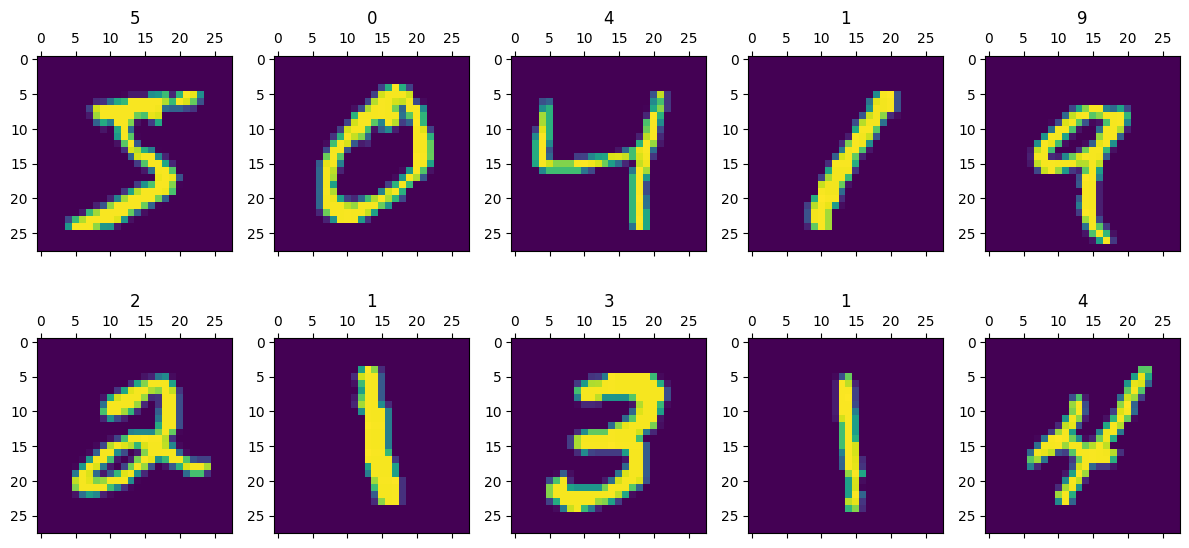

In [2]:
# Load digits data from MNIST dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Print the dimensions of the datasets to verify their size and structure
print("Shape of X_train: ", X_train.shape) # X_train contains the training images
print("Shape of y_train: ", y_train.shape) # y_train contains the training labels
print("Shape of X_test: ", X_test.shape)   # X_test contains the test images
print("Shape of y_test: ", y_test.shape)   # y_test contains the test labels

# Convert the pixel values of images from integers to floats and normalize by dividing by 255
# This scales all pixel values to be between 0 and 1 which aids in the training process
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Display images of the first 10 digits from the training set along with their corresponding labels
# We set up a plotting area using matplotlib, arranging subplots in 2 rows and 5 columns
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0 # Counter to access image index
for i in range(0, 2): # Loop over the rows of subplots
    for j in range(0, 5): # Loop over the columns of subplots
        axs[i,j].matshow(X_train[n]) # Display the n-th image in the ith row and jth column
        axs[i,j].set(title=y_train[n]) # Set the title of subplot to the corresponding label of the image
        n = n + 1 # Increment counter to move to the next image
plt.show() # Render the plot with the images and titles

Note: we got 60,000 images in training set and 10,000 images in test set. And the dimensions of each image is 28 x 28 pixels.
its time to add noise to the images.


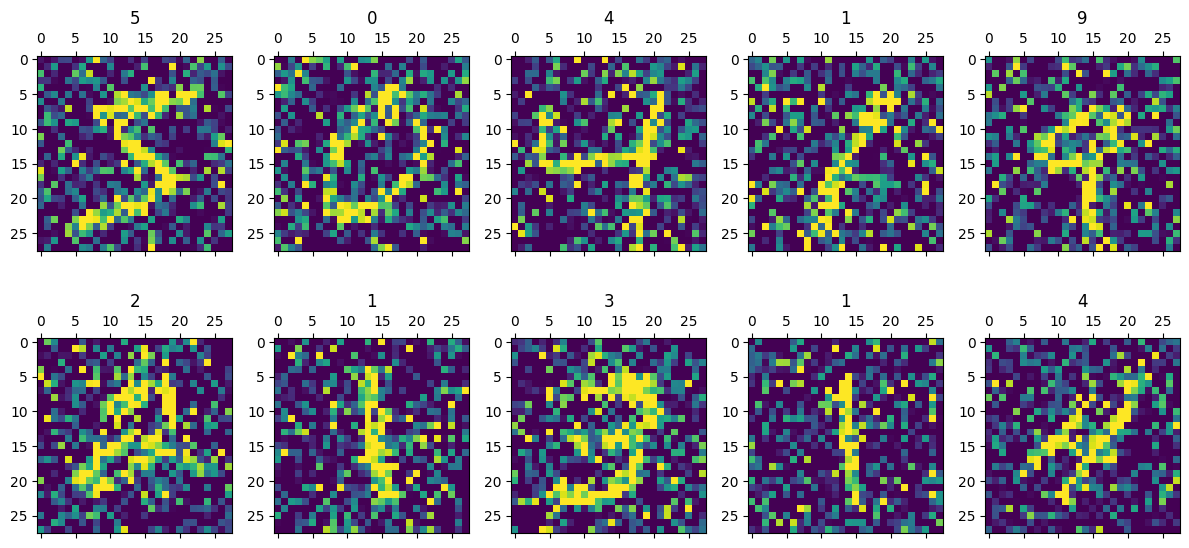

In [3]:
# Specify how much noise to add
level_of_noise=0.5

# Generate random noise by sampling from a Gaussian (normal) distribution and add it to the training and testing images
X_train_noisy = X_train + level_of_noise * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + level_of_noise * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# Enforce min-max boundaries so it does not go beyond [0,1] range
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

# Set up a plot to display the first 10 noisy images from the training set
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n = 0  # Initialize a counter to track the index of images
for i in range(0, 2):  # Loop over two rows of images
    for j in range(0, 5):  # Loop over five columns in each row
        axs[i, j].matshow(X_train_noisy[n])  # Display the n-th noisy image in the grid
        axs[i, j].set(title=y_train[n])  # Set the title of each subplot to show the digit's true label
        n = n + 1  # Increment the image index
plt.show()  # Display the plotted grid of images

In [4]:
# Reshape input data (the original training and testing datasets from 28x28 pixels to a flat array of 784 pixels per image)
X_train = X_train.reshape(60000, 784)  # Reshape 60,000 training images
X_test = X_test.reshape(10000, 784)    # Reshape 10,000 testing images

# Reshape the noisy training and testing datasets in the same way
X_train_noisy = X_train_noisy.reshape(60000, 784)  # Reshape 60,000 noisy training images
X_test_noisy = X_test_noisy.reshape(10000, 784)    # Reshape 10,000 noisy testing images

# Print the new shapes of the datasets to confirm that they have been reshaped correctly
print("New shape of X_train: ", X_train.shape)          # Display the shape of the reshaped training dataset
print("New shape of X_test: ", X_test.shape)            # Display the shape of the reshaped testing dataset

print("New shape of X_train_noisy: ", X_train_noisy.shape)  # Display the shape of the reshaped noisy training dataset
print("New shape of X_test_noisy: ", X_test_noisy.shape)    # Display the shape of the reshaped noisy testing dataset


New shape of X_train:  (60000, 784)
New shape of X_test:  (10000, 784)
New shape of X_train_noisy:  (60000, 784)
New shape of X_test_noisy:  (10000, 784)


# Step 3: Let's build the models

Model: "Denoising-Autoencoder-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input-Layer (InputLayer)    [(None, 784)]             0         
                                                                 
 Encoder-Layer (Dense)       (None, 784)               615440    
                                                                 
 Encoder-Layer-Normalizatio  (None, 784)               3136      
 n (BatchNormalization)                                          
                                                                 
 Encoder-Layer-Activation (  (None, 784)               0         
 LeakyReLU)                                                      
                                                                 
 Middle-Hidden-Layer (Dense  (None, 784)               615440    
 )                                                               
                                       

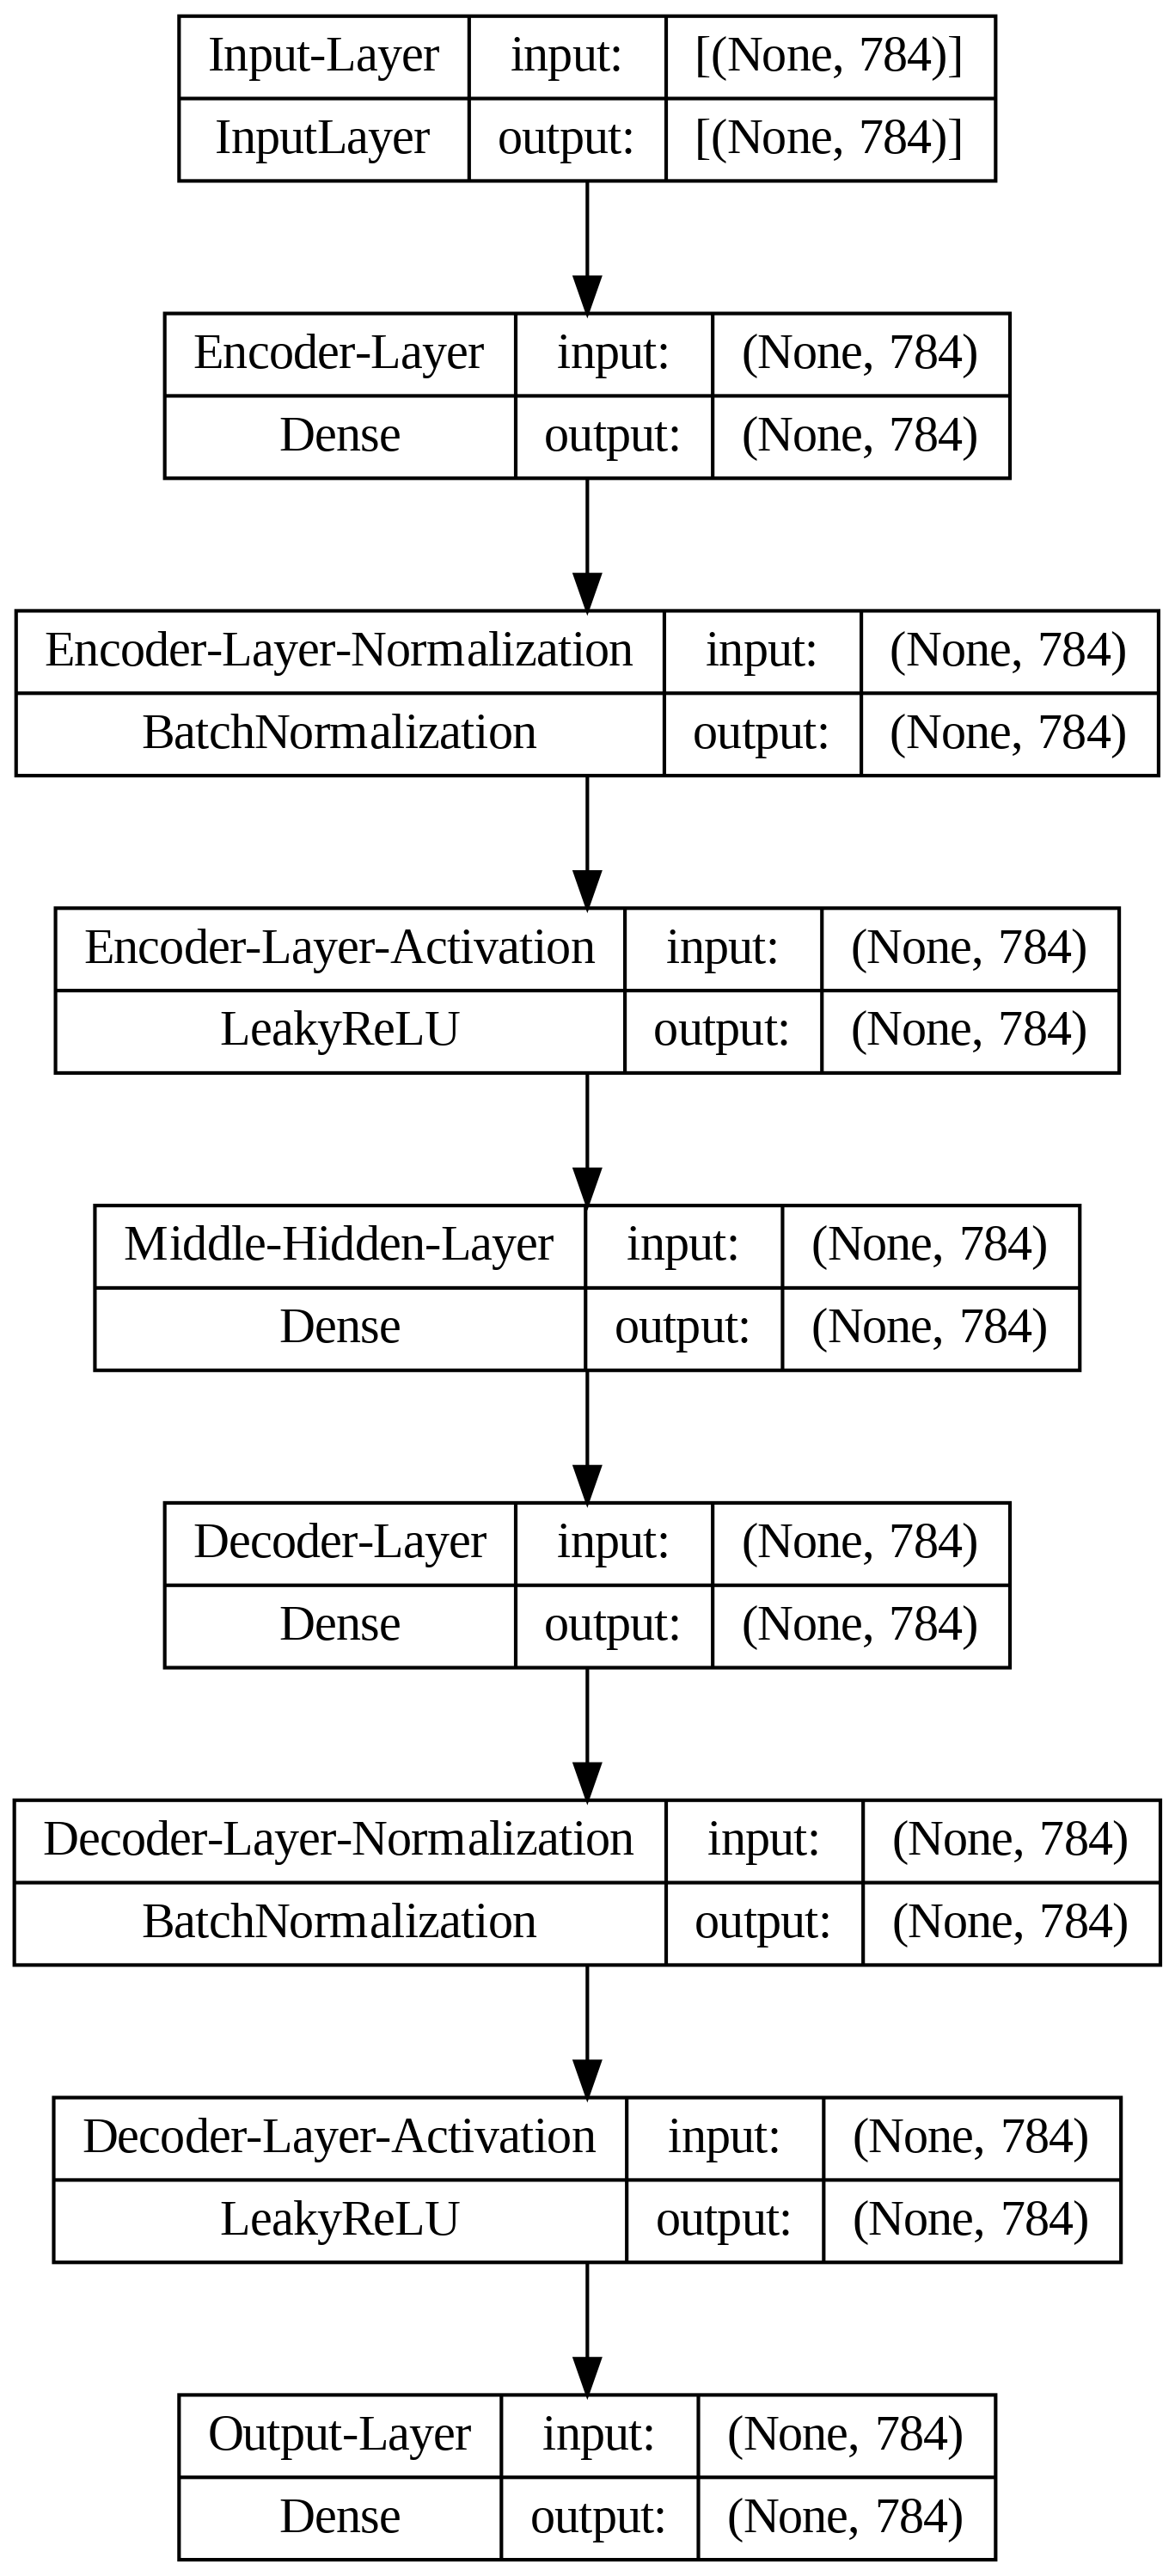

In [5]:
#--- Define Shapes
# Determine the number of input neurons by extracting the number of features from the training data
n_inputs = X_train.shape[1]

#--- Input Layer
# Define the input layer with the specified input shape
visible = Input(shape=(n_inputs,), name='Input-Layer')

#--- Encoder Layer
# Define the encoder layer with a dense (fully connected) layer followed by batch normalization and LeakyReLU activation
e = Dense(units=n_inputs, name='Encoder-Layer')(visible)
e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
e = LeakyReLU(name='Encoder-Layer-Activation')(e)

#--- Middle Layer
# Define the middle layer with a dense layer using linear activation and L1 regularization
middle = Dense(units=n_inputs, activation='linear', activity_regularizer=keras.regularizers.L1(0.0001), name='Middle-Hidden-Layer')(e)

#--- Decoder Layer
# Define the decoder layer with a dense (fully connected) layer followed by batch normalization and LeakyReLU activation
d = Dense(units=n_inputs, name='Decoder-Layer')(middle)
d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
d = LeakyReLU(name='Decoder-Layer-Activation')(d)

#--- Output layer
# Define the output layer with a dense layer using sigmoid activation
output = Dense(units=n_inputs, activation='sigmoid', name='Output-Layer')(d)

# Define the denoising autoencoder model with the input and output layers
model = Model(inputs=visible, outputs=output, name='Denoising-Autoencoder-Model')

# Compile the denoising autoencoder model using the mean squared error (MSE) loss and Adam optimizer
model.compile(optimizer='adam', loss='mse')

# Print the summary of the denoising autoencoder model, including the layers and parameters
print(model.summary())

# Plot the denoising autoencoder model diagram and save it as an image file
plot_model(model, to_file=main_dir+'/content/Denoising_Autoencoder.png', show_shapes=True, dpi=300)

In [6]:
# Fit the Denoising autoencoder model to reconstruct input
history = model.fit(X_train_noisy, X_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test_noisy, X_test))
# just for understanding, read below
# model.fit: This method trains the model on the input data and target data.
# epochs=20: This specifies the number of epochs (iterations over the entire dataset) for training.
# batch_size=32: This determines the number of samples per gradient update. It's a hyperparameter that can affect the training time and model performance.
# verbose=1: This argument controls the verbosity of the training process. Setting it to 1 displays progress bars during training.
# validation_data=(X_test_noisy, X_test): This specifies the validation data, which is used to evaluate the model's performance on a separate dataset during training. It helps monitor overfitting.


Epoch 1/20
1875/1875 [==============================] - 64s 33ms/step - loss: 0.0320 - val_loss: 0.0194
Epoch 2/20
1875/1875 [==============================] - 61s 33ms/step - loss: 0.0189 - val_loss: 0.0175
Epoch 3/20
1875/1875 [==============================] - 74s 40ms/step - loss: 0.0162 - val_loss: 0.0284
Epoch 4/20
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0152 - val_loss: 0.0177
Epoch 5/20
1875/1875 [==============================] - 62s 33ms/step - loss: 0.0147 - val_loss: 0.0221
Epoch 6/20
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0144 - val_loss: 0.0173
Epoch 7/20
1875/1875 [==============================] - 67s 36ms/step - loss: 0.0142 - val_loss: 0.0146
Epoch 8/20
1875/1875 [==============================] - 63s 34ms/step - loss: 0.0139 - val_loss: 0.0140
Epoch 9/20
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0137 - val_loss: 0.0135
Epoch 10/20
1875/1875 [==============================] - 62s 33m

Let's plot the loss chart

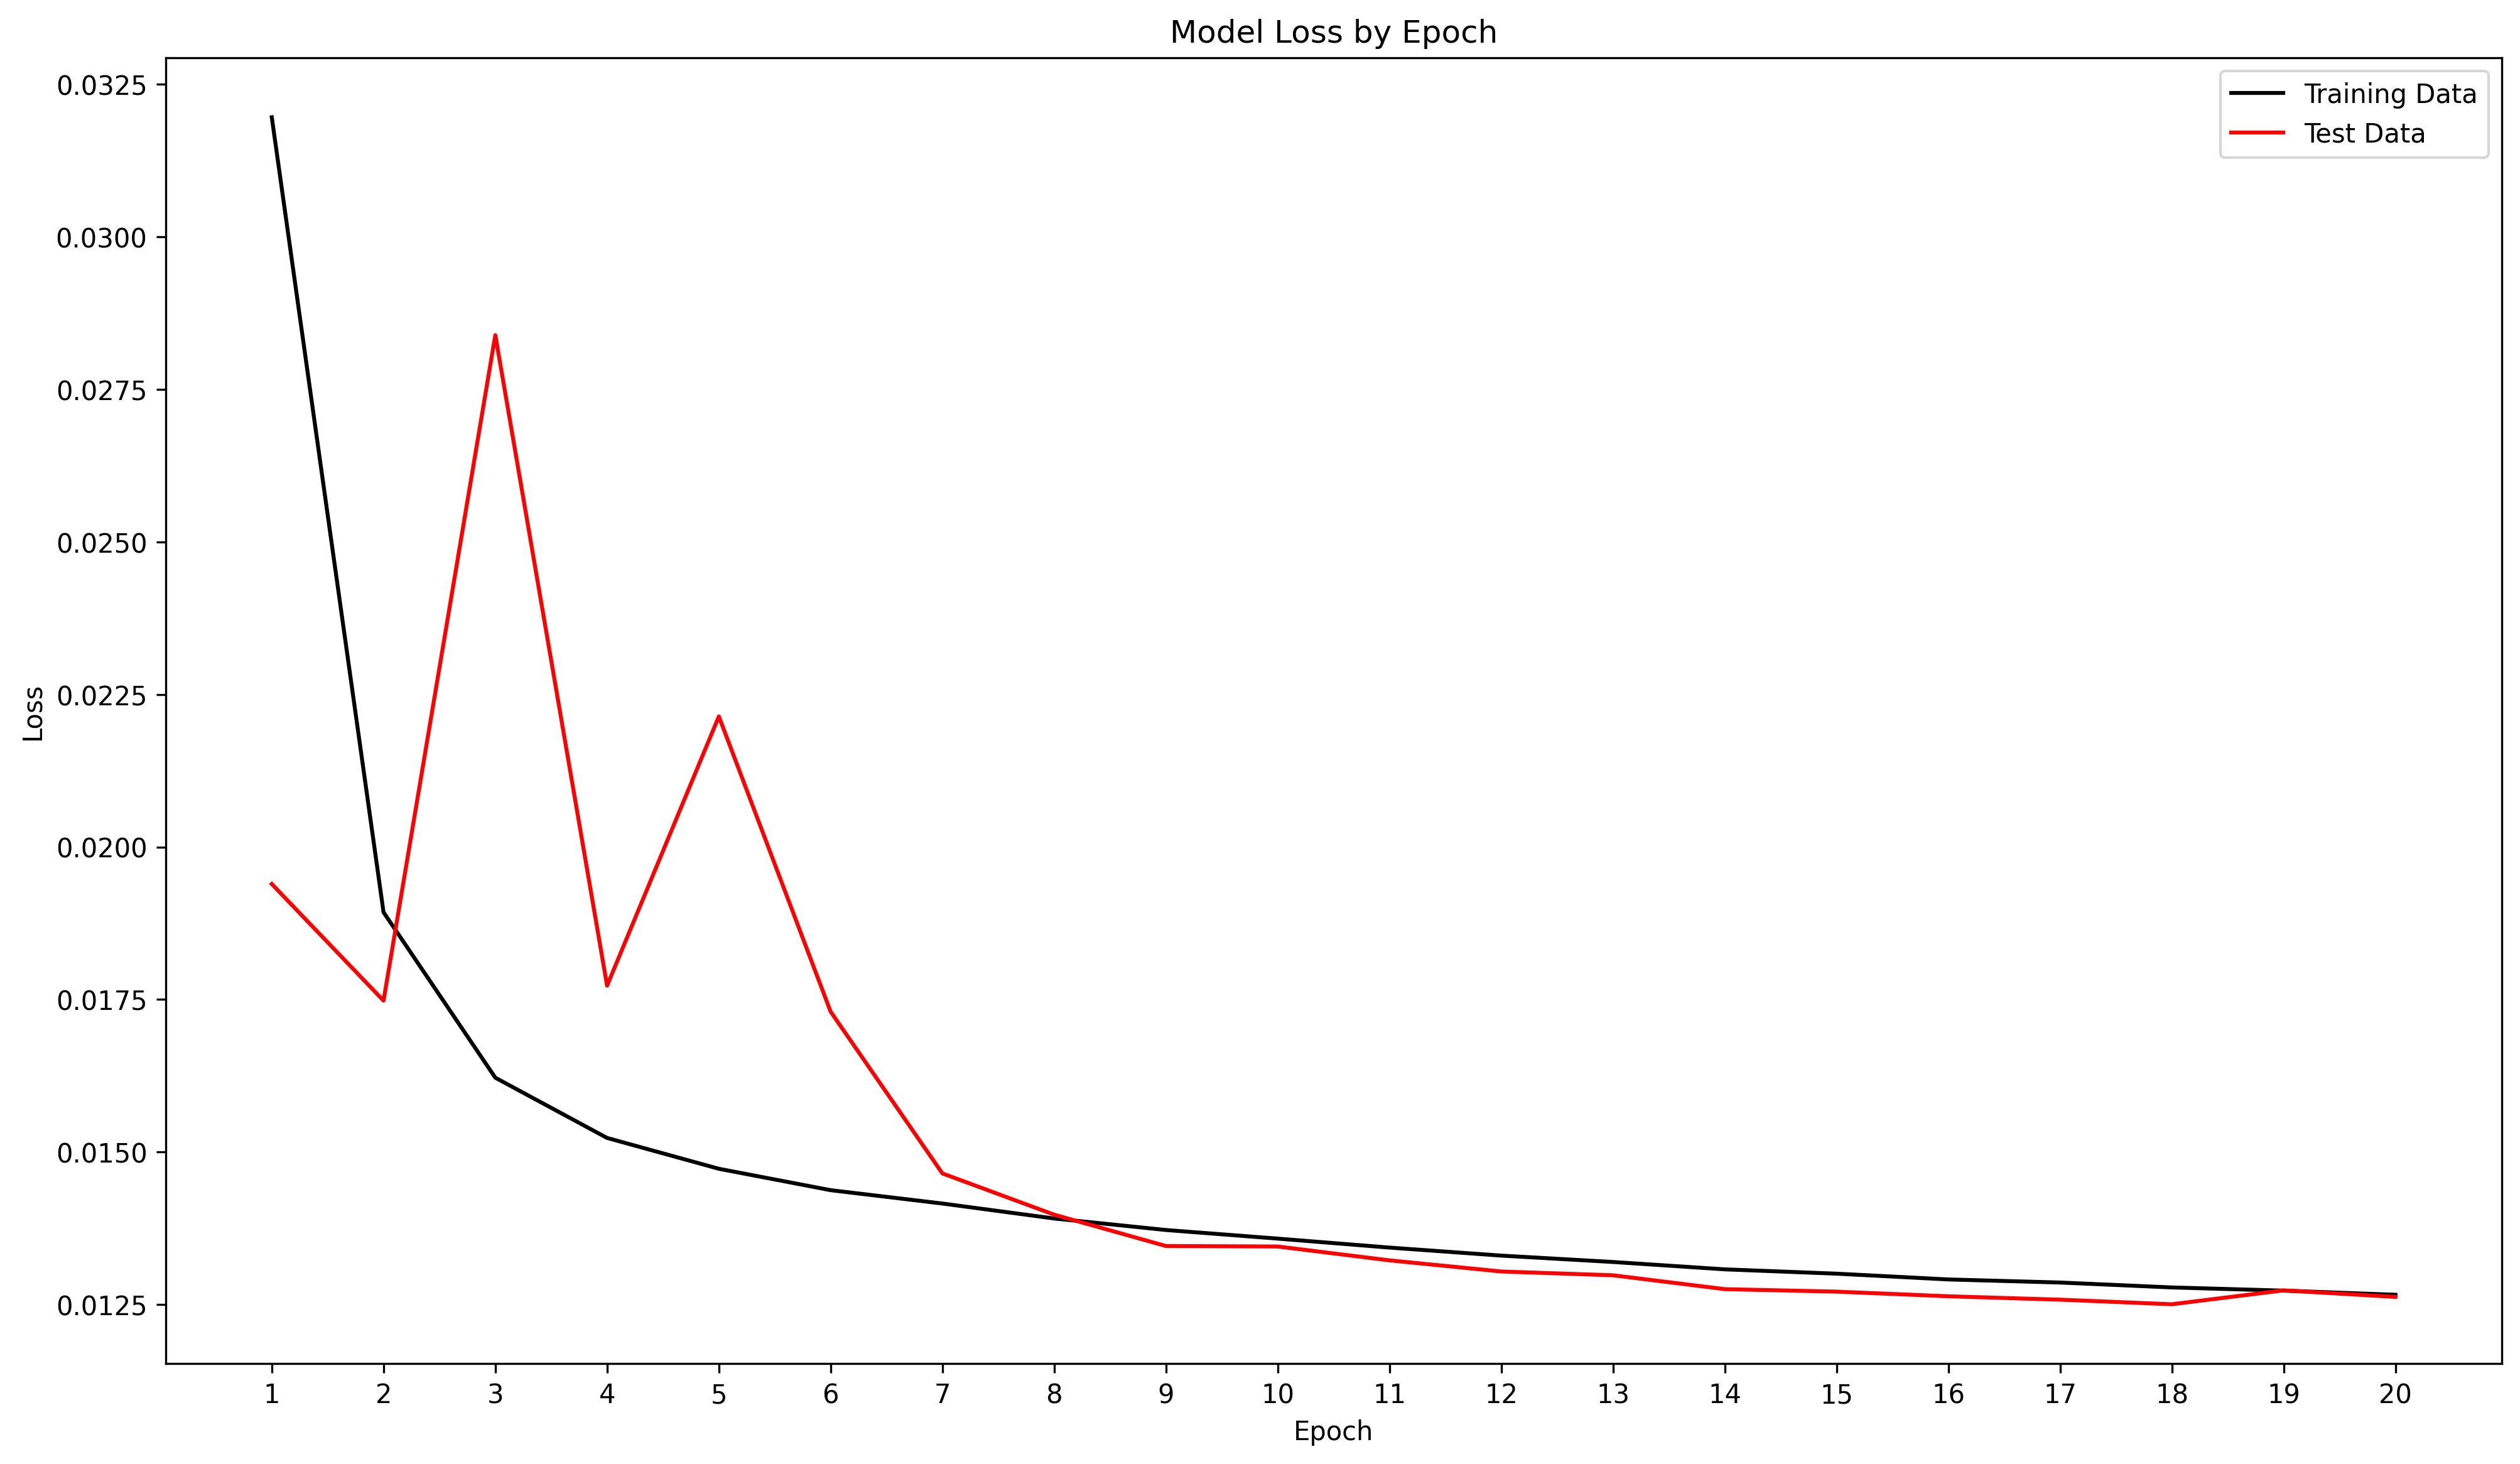

In [7]:
# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)  # Create a figure and axes for the plot with specified size and resolution
plt.title(label='Model Loss by Epoch', loc='center')  # Set the title of the plot

# Plot training loss
ax.plot(history.history['loss'], label='Training Data', color='black')  # Plot the training loss values with a black line

# Plot validation loss
ax.plot(history.history['val_loss'], label='Test Data', color='red')  # Plot the validation loss values with a red line

# Set labels for axes
ax.set(xlabel='Epoch', ylabel='Loss')  # Set the labels for the x and y axes

# Set x-axis ticks and labels
plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))  # Set the x-axis ticks and labels to correspond to the epochs

# Add legend
plt.legend()  # Add a legend to the plot to distinguish between training and validation loss

# Display the plot
plt.show()  # Show the plot

## Step 4 - Display results based on a few images from test data
Original images

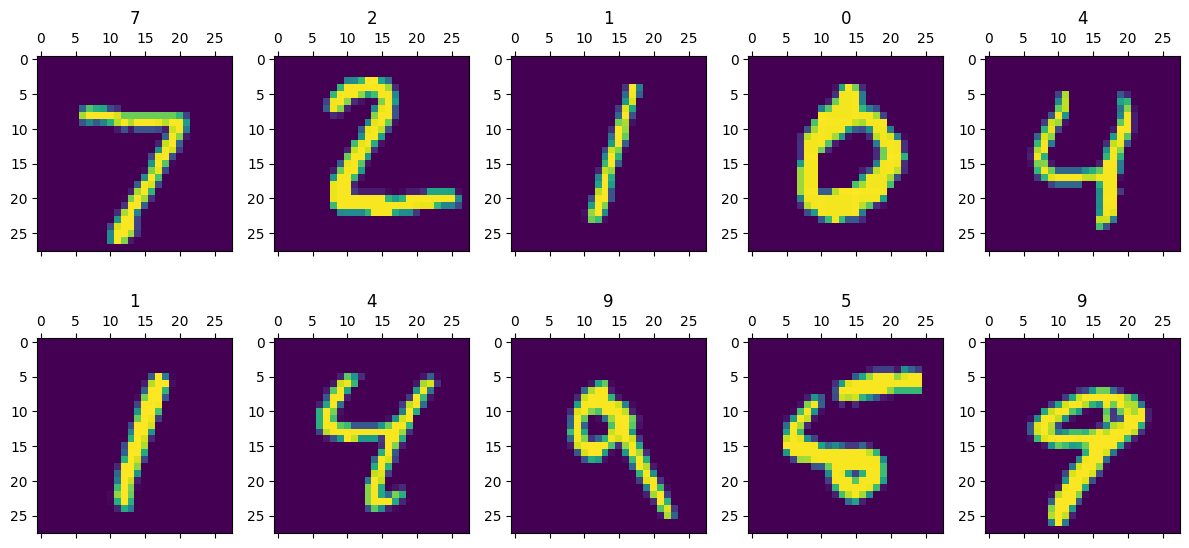

In [8]:
# Reshape the test data back to its original shape
X_test_back = X_test.reshape(10000, 28, 28)

# Display images of the first 10 digits in the original test data
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')  # Create subplots for displaying images
n=0  # Initialize a counter
for i in range(0,2):  # Iterate over rows
    for j in range(0,5):  # Iterate over columns
        axs[i,j].matshow(X_test_back[n])  # Display the image corresponding to the nth digit
        axs[i,j].set(title=y_test[n])  # Set the title of the subplot to the label of the nth digit
        n=n+1  # Increment the counter
plt.show()  # Show the plot containing images of the first 10 digits

Noisy images

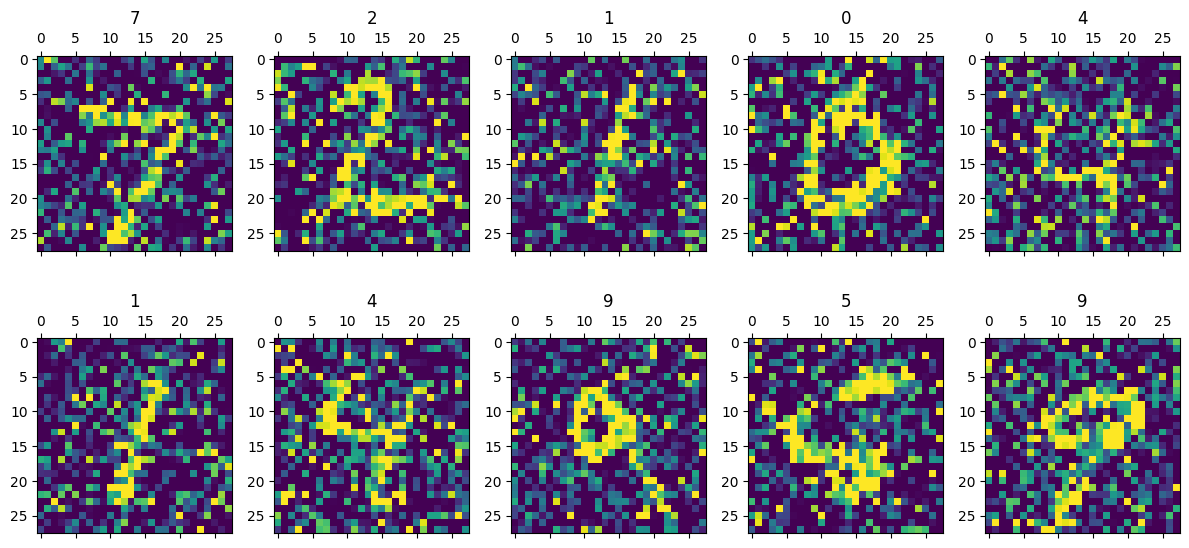

In [9]:
# Reshape the noisy test data back to its original shape
X_test_noisy_reshaped = X_test_noisy.reshape(10000, 28, 28)

# Display images of the first 10 digits in the noisy test data
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')  # Create subplots for displaying images
n=0  # Initialize a counter
for i in range(0,2):  # Iterate over rows
    for j in range(0,5):  # Iterate over columns
        axs[i,j].matshow(X_test_noisy_reshaped[n])  # Display the image corresponding to the nth digit
        axs[i,j].set(title=y_test[n])  # Set the title of the subplot to the label of the nth digit
        n=n+1  # Increment the counter
plt.show()  # Show the plot containing images of the first 10 digits

Images after denoising

313/313 [==============================] - 2s 6ms/step


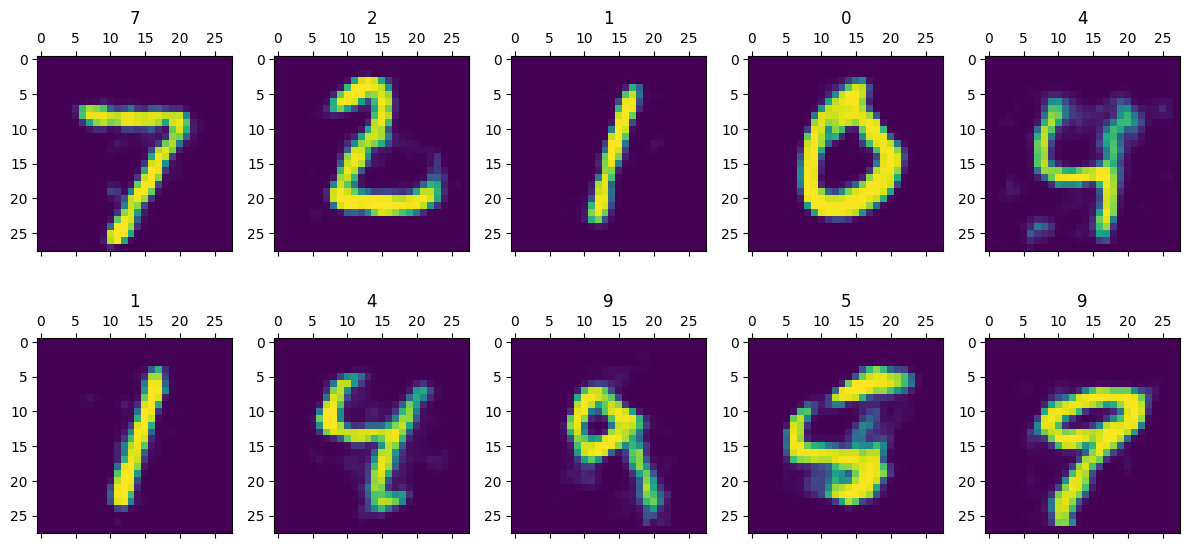

In [10]:
# Apply the denoising autoencoder model to the noisy test data and reshape it back to its original shape
X_test_denoised = model.predict(X_test_noisy).reshape(10000, 28, 28)

# Display images of the first 10 digits after denoising
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')  # Create subplots for displaying images
n=0  # Initialize a counter
for i in range(0,2):  # Iterate over rows
    for j in range(0,5):  # Iterate over columns
        axs[i,j].matshow(X_test_denoised[n])  # Display the denoised image corresponding to the nth digit
        axs[i,j].set(title=y_test[n])  # Set the title of the subplot to the label of the nth digit
        n=n+1  # Increment the counter
plt.show()  # Show the plot containing denoised images of the first 10 digits

In [11]:
# Save the denoising encoder model to file
model.save(main_dir+'/content/denoiser.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<p align="center"><font size = ""><b> -- End of program -- </b><font></p>
<p align="center"><font size = "10"><b> Happy coding! ☺ </b><font></p>